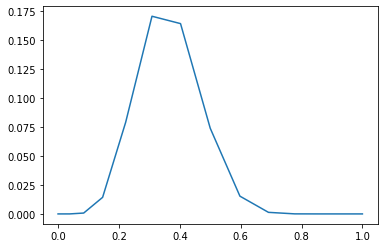

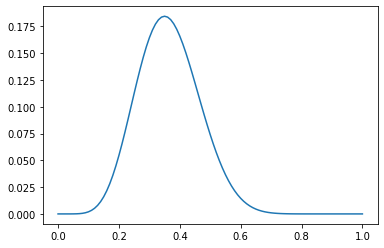

compare
python
[0.0324643, -0.018551, -0.0489072, 0.0408416, 0.0162596, -0.0355769, 0.00641417, 0.0169142, -0.010456, -0.00325559, 0.00548465, -0.000967879, -0.001351, 0.000755239, 5.13269e-05, -0.000168646, 4.76607e-05, 7.33242e-06, -7.33242e-06, 1.6921e-06, -1.41008e-07, 5.48173e-18, 8.88178e-18, -1.16573e-17, -6.66134e-18, 1.55431e-17]


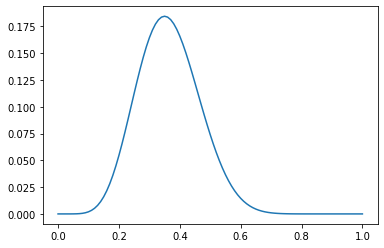

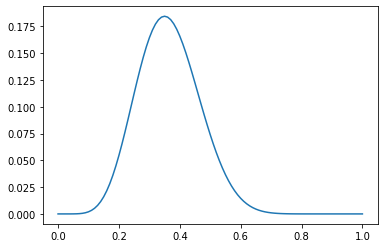

Custom method: 0.000277896525581942
Adaptive-Quadrature method: (0.0010822600994060511, 4.444390837328674e-11)
Integration error:  0.0008043635738241091


/home/marnus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in multiply


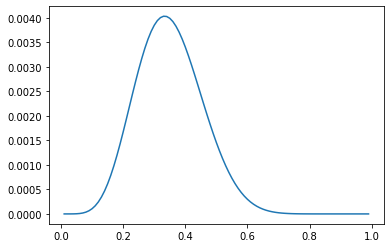

In [520]:
import numpy as np
import scipy.stats as sps
from scipy.special import beta
import scipy.integrate as integrate

def nodes_to_spectral(f,N):
    f1 = np.reshape(f,(len(f),1)) #Need input as a column vector
    f2 = np.reshape(np.flip(f[1:-1], axis = 0),(len(f)-2,1)) #Need to make some alteration before we apply the inverse FFT 
    f = np.real(np.fft.ifft(np.append(f1,f2))) #Apply the inverse fourier transform and throw away the complex values 
    spectral_coefficients = np.append(f[0], 2*f[1:N-1]) #Get the Chebyshev coefficients
    spectral_coefficients = np.append(spectral_coefficients, f[N])
    return spectral_coefficients

def ClenshawCurtis_v2(c):
    integral = 0    
    for k in range(0,len(c)):
        if k % 2 == 0:
            integral += c[k]/(1-k**2)
    return integral

def spectral_to_nodes(c,N):
    c = np.reshape(c,(len(c),1)) #This is to get a column vector, since the fourier transform output depends on the orientation
    cc = np.append(c[1:],np.flip(c[1:-1], axis = 0))/2 #Need to make some changes in order to get the Chebyshev coefficients
    ap = np.append(c[0], cc)#Apply the FFT and throw away the complex values
    F=np.real(np.fft.fft(ap))
    function_values=F[0:N] 
    return function_values

def fast_root_solver(λf):
    '''Get the Chebychev coefficients of g(x) where f(x) = x(1-x)g(x)  '''
    λg_even = uband_solver_2(λf[2::2],"Odd")
    λg_odd = uband_solver_2(λf[3::2],"Even")
    λg = np.zeros(len(λg_odd) + len(λg_even))
    '''Sorry for the vector usage, but we are just splicing the solution 
        back together sol_even = [ e e ... e e]
        sol_odd = [ o o ... o o] , then we have sol = [e o e o ... e o e o]'''
    λg[0::2] = λg_even
    λg[1::2] = λg_odd
    #print("sol",sol)
    return λg

def uband_solver_2(λ1,flag):
    '''Backward subsitution for an upper matrix diagonal matrix w. upperband 2 (not general)  '''
    n = len(λ1)
    λ2 = np.zeros(n)
    λ2[-1] = -16*λ1[-1]
    λ2[-2] = -16*((-1/8)*λ2[-1]+ λ1[-2])
    for i in range(n-3, -1, -1):    
        λ2[i] = -16*((-1/8)*λ2[i+1] + (1/16)*λ2[i+2] + λ1[i])  
    if flag == "Odd":
        λ2[0] = -8*((-1/8)*λ2[1] + (1/16)*λ2[2] + λ1[0])
    return λ2

def get_Chebypoints(N):
    xx = N
    circle = -np.arange(0,np.pi+np.pi/(xx-1),np.pi/(xx-1))
    #print("circle=", circle)
    x = (np.cos(circle) + 1)/2
    return x    
 
    
def integrate_root(α,β,λ,f0,f1):
    root_int = 0
    A = 1/beta(α,β)
    λ_g = fast_root_solver(λ)
    pg = spectral_to_nodes(λ_g,N-2)
    x = get_Chebypoints(N-2)
    pab = ((x)**α)*((1-x)**β)
    pr = pab*pg    
    λ_p = nodes_to_spectral(pr,N-2)
    root_int += A*ClenshawCurtis_v2(λ_p)
    root_int += f0 + α/(α+β)*(f1-f0)
    return root_int

N=17
beta_1 = 0.01
beta_2 = 0.01
n = 20
m = 7
x = get_Chebypoints(N)

ℓ_f = sps.binom.pmf(m, n, x, loc=0)  
plt.plot(x,ℓ_f)
plt.show()


λ_f = [0.0324643,-0.018551,-0.0489072,0.0408416,0.0162596,-0.0355769,0.00641417,0.0169142,-0.010456,-0.00325559,0.00548465,-0.000967879,-0.001351,0.000755239,5.13269e-05,-0.000168646,4.76607e-05,7.33242e-06,-7.33242e-06,1.6921e-06,-1.41008e-07,5.48173e-18,8.88178e-18,-1.16573e-17,-6.66134e-18,1.55431e-17]

p = np.arange(-1,1.02,0.02)
y = ch.chebval(p,λ_f)
pp = np.arange(0,1.01,0.01)
plt.plot(pp,y)
plt.show()


print("compare")
print("python")
print(λ_f)
p = np.arange(-1,1.02,0.02)
y = ch.chebval(p,λ_f)
pp = np.arange(0,1.01,0.01)
plt.plot(pp,y)
plt.show()

λ_g = fast_root_solver(λ_f)
#print(λ_g)
#λ_g = np.linalg.solve(A2(N), λ_f[2:])
#print(λ_g)

p = np.arange(-1,1.02,0.02)
y = ch.chebval(p,λ_g)


yy = pp*(1-pp)*y +ℓ_f[-1]+pp*(ℓ_f[0] - ℓ_f[-1]) 
plt.plot(pp,yy)
plt.show()


approx = integrate_root(beta_1,beta_1,λ_f,ℓ_f[-1],ℓ_f[0])
print("Custom method:", approx)
f = lambda p: sps.binom.pmf(m, n, p, loc=0)*sps.beta.pdf(p,beta_1,beta_2)
exact = integrate.quad(f, 0, 1)
print("Adaptive-Quadrature method:", exact)
print("Integration error: ", abs(exact[0]-approx))

pp = np.arange(0,1.01,0.01)
plt.plot(pp,f(pp))
plt.show()


[[-0.125   0.      0.125   0.     -0.0625  0.      0.      0.    ]
 [ 0.     -0.0625  0.      0.125   0.     -0.0625  0.      0.    ]
 [ 0.      0.     -0.0625  0.      0.125   0.     -0.0625  0.    ]
 [ 0.      0.      0.     -0.0625  0.      0.125   0.     -0.0625]
 [ 0.      0.      0.      0.     -0.0625  0.      0.125   0.    ]
 [ 0.      0.      0.      0.      0.     -0.0625  0.      0.125 ]
 [ 0.      0.      0.      0.      0.      0.     -0.0625  0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.     -0.0625]]
[ 1.23092340e+00  1.61081737e+00  1.86487718e+00  2.01261294e+00
  2.07213173e+00  2.06008185e+00  1.99162210e+00  1.88041341e+00
  1.73862998e+00  1.57698768e+00  1.40478707e+00  1.22996915e+00
  1.05918151e+00  8.97853180e-01  7.50276225e-01  6.19692618e-01
  5.08384725e-01  4.17768091e-01  3.48485245e-01  3.00499353e-01
  2.73186692e-01  2.65427015e-01  2.75690966e-01  3.02123838e-01
  3.42625026e-01  3.94922650e-01  4.56642899e-01  5.25373731e-01
  5.9872

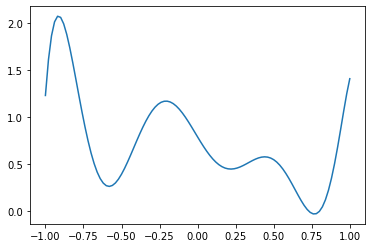

[1.51482368 1.90231397 2.16397011 2.3193022  2.38641731 2.38196375
 2.32110033 2.21748796 2.08330086 1.92925488 1.7646506  1.597429
 1.43423769 1.28050568 1.14052506 1.01753777 0.9138262  0.8308059
 0.76911938 0.72872981 0.70901347 0.70885012 0.7267104  0.76073959
 0.80883711 0.86873106 0.93804763 1.01437479 1.09532003 1.17856206
 1.26189616 1.34327326 1.42083268 1.49292865 1.55815066 1.61533786
 1.66358773 1.70225932 1.73097127 1.74959511 1.75824405 1.75725783
 1.74718399 1.72875595 1.70286858 1.67055151 1.63294083 1.5912497
 1.54673821 1.50068322 1.45434853 1.40895586 1.36565722 1.32550908
 1.28944868 1.25827304 1.23262098 1.21295844 1.19956752 1.1925394
 1.19177145 1.19696859 1.20764914 1.22315511 1.24266704 1.26522314
 1.28974284 1.31505428 1.33992568 1.36309999 1.3833326  1.3994314
 1.41029853 1.4149733  1.41267511 1.40284578 1.38518994 1.35971247
 1.32675172 1.287007   1.24155894 1.19188085 1.13983966 1.08768401
 1.03801796 0.9937576  0.95806861 0.93428198 0.92578533 0.93588703
 

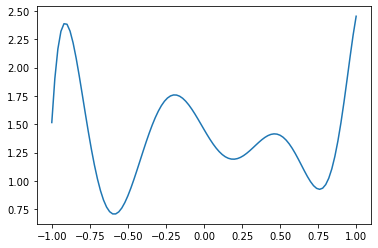

67.03536953000025


In [303]:
'''
TEST IF \bf{A} IS DERIVED CORRECTLY
Note - Both systems (A2(10), λ[2:]) and  (A(10), λ[:-2])
give the same coefficients
''' 
import scipy as sp
%matplotlib inline
import numpy.polynomial.chebyshev as ch
import matplotlib.pyplot as plt
import numpy as np

def A(K): 
    A = sp.sparse.diags([-1/16, 1/8, -1/16], [-2, 0, 2], shape=(K-2, K-2)).toarray()
    A[1,1] = 1/16
    A[2,0] = -1/8
    return A

def A2(K): 
    A = sp.sparse.diags([-1/16, 1/8, -1/16], [0, 2, 4], shape=(K-2, K-2)).toarray()
#    A[1,1] = 1/16
    A[0,0] = -1/8
    return A


def update_λ(λ,f0,f1):
    λ[0] = λ[0] - (f0 + 0.5*(f1-f0))
    λ[1] =  λ[1] - (0.5*(f1-f0))
    return λ

λ = np.array([1.53595217, -0.04302306,  0.38219178,  0.06157884,  0.34973255,  0.20083153, -0.11754758,  0.33277194, -0.16669199, -0.083346])
λ = update_λ(λ,0.2309234, 0.4089174)
λ_g = np.linalg.solve(A2(10), λ[2:])

print(A2(10))

p = np.arange(-1,1.02,0.02)
y = ch.chebval(p,λ_g)

pp = np.arange(0,1.01,0.01)

yy = pp*(1-pp)*y +1.2309234+ pp*(1.4089174 - 1.2309234) 
plt.plot(p,yy)
print(yy)
plt.show()


coeff = np.array([1.53595217, -0.04302306,  0.38219178,  0.06157884,  0.34973255,  0.20083153, -0.11754758,  0.33277194, -0.16669199, -0.083346])
x = np.arange(-1,1.02,0.02)
y = ch.chebval(x,coeff)
print(y)
plt.plot(x,y)
plt.show()

print(np.sum(y - yy))

In [477]:
'''
TEST IF FAST SOLVER WORKS CORRECTLY
''' 
def fast_root_solver(λf):
    '''Get the Chebychev coefficients of g(x) where f(x) = x(1-x)g(x)  '''
    λg_even = uband_solver_2(λf[2::2],"Odd")
    λg_odd = uband_solver_2(λf[3::2],"Even")
    λg = np.zeros(len(λg_odd) + len(λg_even))
    '''Sorry for the vector usage, but we are just splicing the solution 
        back together sol_even = [ e e ... e e]
        sol_odd = [ o o ... o o] , then we have sol = [e o e o ... e o e o]'''
    λg[0::2] = λg_even
    λg[1::2] = λg_odd
    #print("sol",sol)
    return λg

def uband_solver_2(λ1,flag):
    '''Backward subsitution for an upper matrix diagonal matrix w. upperband 2 (not general)  '''
    n = len(λ1)
    λ2 = np.zeros(n)
    λ2[-1] = -16*λ1[-1]
    λ2[-2] = -16*((-1/8)*λ2[-1]+ λ1[-2])
    for i in range(n-3, -1, -1):  
        λ2[i] = -16*((-1/8)*λ2[i+1] + (1/16)*λ2[i+2] + λ1[i])  
    if flag == "Odd":
        λ2[0] = -8*((-1/8)*λ2[1] + (1/16)*λ2[2] + λ1[0])
    return λ2

λ = np.array([0.0324643,-0.018551,-0.0489072,0.0408416,0.0162596,-0.0355769,0.00641417,0.0169142,-0.010456,-0.00325559,0.00548465,-0.000967879,-0.00135114,0.000756931,4.39945e-05,-0.000161313,9.53214e-05])
λ_g = np.linalg.solve(A2(17), λ[2:])
print("Standard NUMPY Solver")
print(λ_g)

print("Fast Solver")
print(fast_root_solver(λ))


Standard NUMPY Solver
[ 0.14866038 -0.09569664 -0.22134491  0.20112014  0.04250463 -0.15552867
  0.04620056  0.05705291 -0.05273023 -0.0009927   0.01563499 -0.00694888
 -0.0037542   0.00258101 -0.00152514]
Fast Solver
[ 0.14866038 -0.09569664 -0.22134491  0.20112014  0.04250463 -0.15552867
  0.04620056  0.05705291 -0.05273023 -0.0009927   0.01563499 -0.00694888
 -0.0037542   0.00258101 -0.00152514]


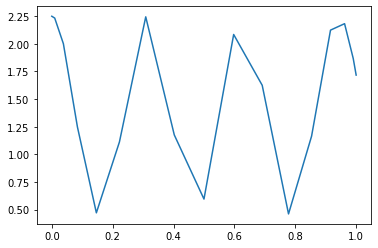

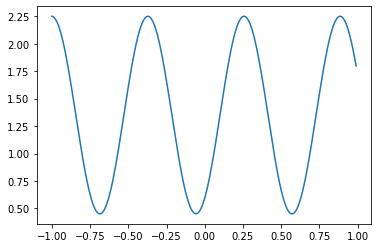

0
2
4
6
8
10
12
14
16
1.3910805437286171
(1.3910825362827433, 3.6975319182321054e-13)


In [387]:
'''
TEST CLENSHAW-CURTIS INTEGRATION (so dumb...)
''' 
import numpy.polynomial.chebyshev as ch

def ClenshawCurtis_v2(c):
    integral = 0    
    for k in range(0,len(c)):
        if k % 2 == 0:
            integral += c[k]/(1-k**2)
    return integral

N= 17
x = get_Chebypoints(N)
#x = np.flip(x)
root_f = 0.9*(np.cos(20*x)+1.5)
#print(root_f)
plt.plot(x,root_f)
plt.show()

λ = nodes_to_spectral(root_f,N)
x = np.arange(-1,1,0.01)
y = ch.chebval(x,λ)
plt.plot(x,y)
plt.show()


print(ClenshawCurtis_v2(λ))
#print(λ)

f = lambda p: 0.9*(np.cos(20*p)+1.5)
exact = integrate.quad(f, 0, 1)
print(exact)


Integration:
0.047618881524820654
λ_g:
[ 0.14866038 -0.09569664 -0.22134491  0.20112014  0.04250463 -0.15552867
  0.04620056  0.05705291 -0.05273023 -0.0009927   0.01563499 -0.00694888
 -0.0037542   0.00258101 -0.00152514]
points (Forward FFT)
[-2.40041816e-02 -8.04174484e-03  3.46009753e-04 -1.33947773e-03
  4.17191854e-04  1.92858324e-03  4.85497582e-02  2.94952513e-01
  7.28265317e-01  7.34557498e-01  2.82650624e-01  3.15663157e-02
  6.47099404e-04 -7.66304021e-03 -2.71785176e-02]


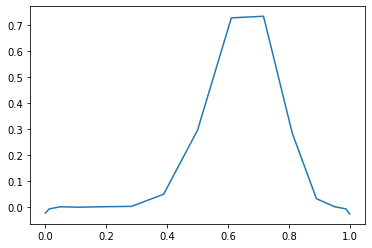

coefficients (Bacward FFT)
[ 1.03886    -0.115549   -0.893092    0.268668    0.561506   -0.266585
 -0.248495    0.167296    0.0699159  -0.0699689  -0.00825831  0.018861
 -0.00176781 -0.002722   -0.001361  ]


In [485]:
'''TEST C OUTPUT'''
def integrate_root(α,β,λ,f0,f1,N):
    root_int = 0
    A = 1/beta(α,β)
    λ_g = fast_root_solver(λ)
    print("λ_g")
    print(λ_g)
    pg = spectral_to_nodes(λ_g,N-2)
    print("pg")
    print(pg)
    print("λ_g")
    print(nodes_to_spectral(pg,N-2))
    x = get_Chebypoints(N-2)
    pab = (x)*(1-x)
    pr = pab*pg    
    λ_p = nodes_to_spectral(pr,N-2)
    root_int += A*ClenshawCurtis_v2(λ_p)
    root_int += f0 + α/(α+β)*(f1-f0)
    return root_int

λ = [0.0324643,-0.018551,-0.0489072,0.0408416,0.0162596,-0.0355769,0.00641417,0.0169142,-0.010456,-0.00325559,0.00548465,-0.000967879,-0.00135114,0.000756931,4.39945e-05,-0.000161313,9.53214e-05]


print("Integration:")
print(ClenshawCurtis_v2(λ))

print("λ_g:")
print(fast_root_solver(λ))   
λ_g = fast_root_solver(λ)

print("points (Forward FFT)")
ℓ_g = spectral_to_nodes(λ_g,len(λ_g))
print(ℓ_g)

plt.plot(np.flip(x),ℓ_g)
plt.show()

print("coefficients (Bacward FFT)")
λ_2 = nodes_to_spectral(ℓ_2,len(ℓ_2))
print(λ_2)